In [1]:
import random
from copy import deepcopy
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)

# linestyles for graphics
line_styles = [
    'solid',
    'dotted',
    'dashdot',
]

# colors for graphics
line_colors = [
    'darkgreen',
    'firebrick',
    'chocolate',
    'gold',
    'violet',
    'palegreen'
]

In [2]:
sql_query_get_avg_min = """
    select
        s.algorithm_name as name,
        s.iteration as iteration,
        avg(s.minimum) as avg_minimum
    from statistics s
    where s.experiment_name = NUMEXP
    group by 
        s.algorithm_name, s.iteration
    ;
    """

In [3]:
sql_query_get_avg_qualities = """
    select
        q.algorithm_name as name,
        q.iteration as iteration,
        avg(quality) as avg_quality
    from qualities q
    where q.experiment_name = NUMEXP
    group by
        q.algorithm_name, q.iteration 
    ;
    """

In [4]:
import sqlite3

In [5]:
def get_data_from_db(num_exp):
    db = sqlite3.connect('coevolution.db')
    cursor = db.cursor()
    res = cursor.execute(sql_query_get_avg_min.replace('NUMEXP', str(num_exp)))
    minimum_metrics = res.fetchall()
    db.commit()

    res = cursor.execute(sql_query_get_avg_qualities.replace('NUMEXP', str(num_exp)))
    qualities_metrics = res.fetchall()
    db.commit()

    db.close()
    
    return minimum_metrics, qualities_metrics

In [6]:
def get_qualities(qualities_metrics):
    qualities_metrics = sorted(qualities_metrics)
    quality_dict = {}
    for metric in qualities_metrics:
        if 'sep' in metric[0]:
            continue
        if quality_dict.get(metric[0]):
            quality_dict[metric[0]].append(metric[2])
        else:
            quality_dict[metric[0]] = [metric[2]]

    for alg in quality_dict.keys():
        plt.plot(
            quality_dict[alg], 
            label=alg, 
            linestyle=random.choice(line_styles)
        )

        plt.title('GEP qualities')
        plt.legend(loc="best")
        plt.xlabel('algorithm iterations')
        plt.ylabel('algorithm qualities')
    plt.show()

In [7]:
def get_minimums(minimum_metrics):
    minimum_metrics = sorted(minimum_metrics)
    minimum_dict = {}
    minimum_y = None
    maximum_y = None
    minimum_alg = None
    coev_len = 0
    for metric in minimum_metrics:
        
        if metric[1] == 1:
            continue
        
        if 'coev' in metric[0]:
            if metric[1] > coev_len:
                coev_len = metric[1]

        _minimum = metric[2]*1_000_000

        if minimum_dict.get(metric[0]):
            minimum_dict[metric[0]].append(_minimum)
        else:
            minimum_dict[metric[0]] = [_minimum]

        if minimum_y:
            if _minimum < minimum_y:
                minimum_alg = metric[0]
                minimum_y = _minimum
        else:
            minimum_alg = metric[0]
            minimum_y = _minimum
            
        if maximum_y:
            if _minimum > maximum_y:
                maximum_y = _minimum
        else:
            maximum_y = _minimum
    
    print(f'\nThe global minimum is: {minimum_y}')
    print(f'The global maximum is: {maximum_y}\n')
    
    _step = (maximum_y - minimum_y) / 100
    
    # calculate erorrs 1% and 5%
    for alg in minimum_dict.keys():
        _to_1 = 0
        _1_to_5 = 0
        _5_to = 0
        for metric in minimum_dict[alg]:
            if metric < minimum_y + _step:
                _to_1 += 1
            elif minimum_y + _step <= metric < minimum_y + (_step * 5):
                _1_to_5 += 1
            else:
                _5_to += 1
                
        print(f'Algorithm {alg}')
        print(f'\tValues best+1%: {_to_1}; {round(_to_1/len(minimum_dict[alg])*100)}% of population')
        print(f'\tValues between best+1% and best+5%: {_1_to_5}; {round(_1_to_5/len(minimum_dict[alg])*100)}% of population')
        print(f'\tValues greater than best+5%: {_5_to}; {round(_5_to/len(minimum_dict[alg])*100)}% of population')

    _line_colors = deepcopy(line_colors)
    _current_color = None
    _current_color_counter = 0
    max_len = 0

    for alg in minimum_dict.keys():
        
        if max_len < len(minimum_dict[alg]):
            max_len = len(minimum_dict[alg])
        
        if _current_color_counter == 2:
            _line_colors = _line_colors[1:]
            _current_color = None
            _current_color_counter = 0

        if _current_color is None:
            _current_color = _line_colors[0]

        if 'coev' in alg:
            linestyle = 'solid'
        else:
            linestyle = 'dashdot'
        plt.plot(
            minimum_dict[alg], 
            label=alg, 
            linestyle=linestyle,
            color=_current_color
        )
        plt.title('GEP minimums')
        plt.xlabel('algorithm iterations')
        plt.ylabel('algorithm qualities')

        _current_color_counter += 1

    plt.plot(
        list(range(max_len)), 
        [minimum_y] * max_len, 
        linestyle='dashed', 
        color='b', 
        label=f'minimum_{minimum_alg}'
    )
    
    plt.fill_between(
        list(range(max_len)), 
        [minimum_y] * max_len,
        [minimum_y + _step] * max_len,
        label=f'minimum_{minimum_alg} + 1%',
        alpha=0.3,
    )
    
    plt.fill_between(
        list(range(max_len)), 
        [minimum_y + _step] * max_len,
        [minimum_y + 5 * _step] * max_len,
        label=f'minimum_{minimum_alg} + 5%',
        alpha=0.5,
    )
    
    plt.axvline(
        coev_len-2, 
        c='black', 
        linestyle='dashed', 
        label='coevolution stop'
    )

    plt.legend(loc="best")
    plt.grid()
    plt.show()

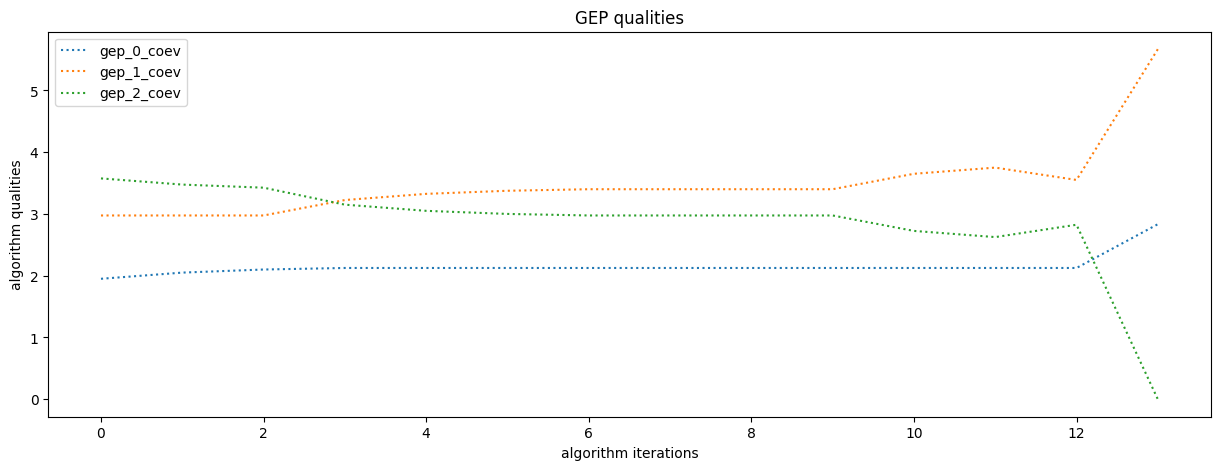


The global minimum is: 20.094979325522043
The global maximum is: 20.941559544786116

Algorithm gep_0_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 1; 6% of population
	Values greater than best+5%: 17; 94% of population
Algorithm gep_0_sep
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 17; 44% of population
	Values greater than best+5%: 22; 56% of population
Algorithm gep_1_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 1; 6% of population
	Values greater than best+5%: 17; 94% of population
Algorithm gep_1_sep
	Values best+1%: 15; 38% of population
	Values between best+1% and best+5%: 11; 28% of population
	Values greater than best+5%: 13; 33% of population
Algorithm gep_2_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 18; 100% of population
Algorithm gep_2_sep
	Values best+1%: 8; 21% of population
	Values between 

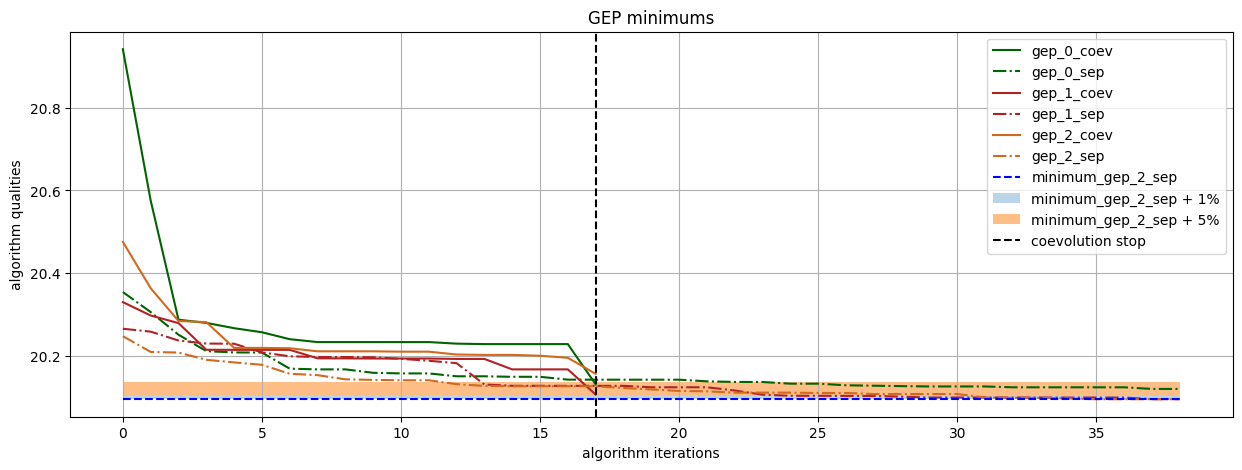

In [8]:
minimum_metrics, qualities_metrics = get_data_from_db('0')
get_qualities(qualities_metrics)
get_minimums(minimum_metrics)

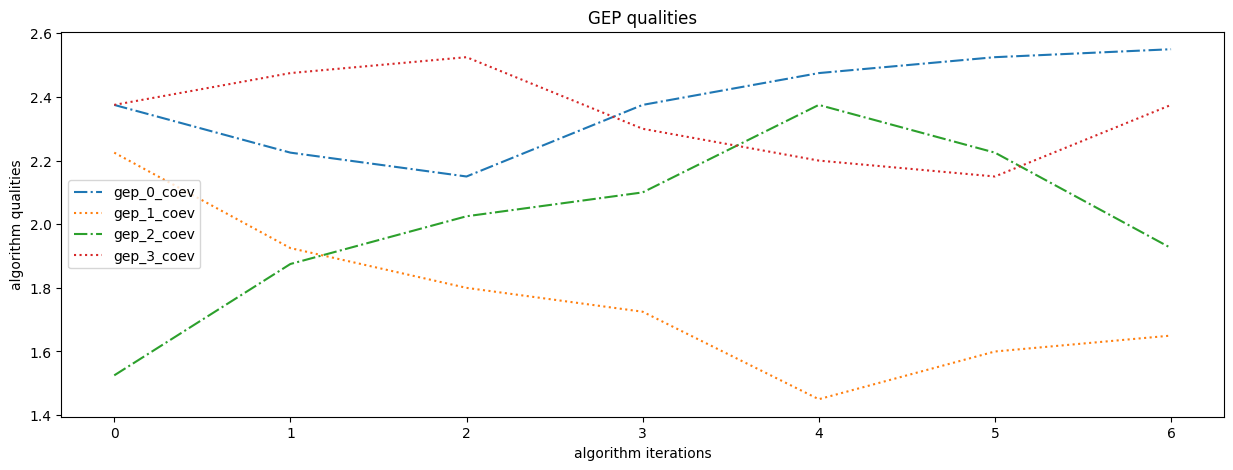


The global minimum is: 22.532685873212866
The global maximum is: 24.194181454958628

Algorithm gep_0_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_0_sep
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 39; 100% of population
Algorithm gep_1_coev
	Values best+1%: 2; 18% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 9; 82% of population
Algorithm gep_1_sep
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 39; 100% of population
Algorithm gep_2_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_2_sep
	Values best+1%: 0; 0% of population
	Values between best

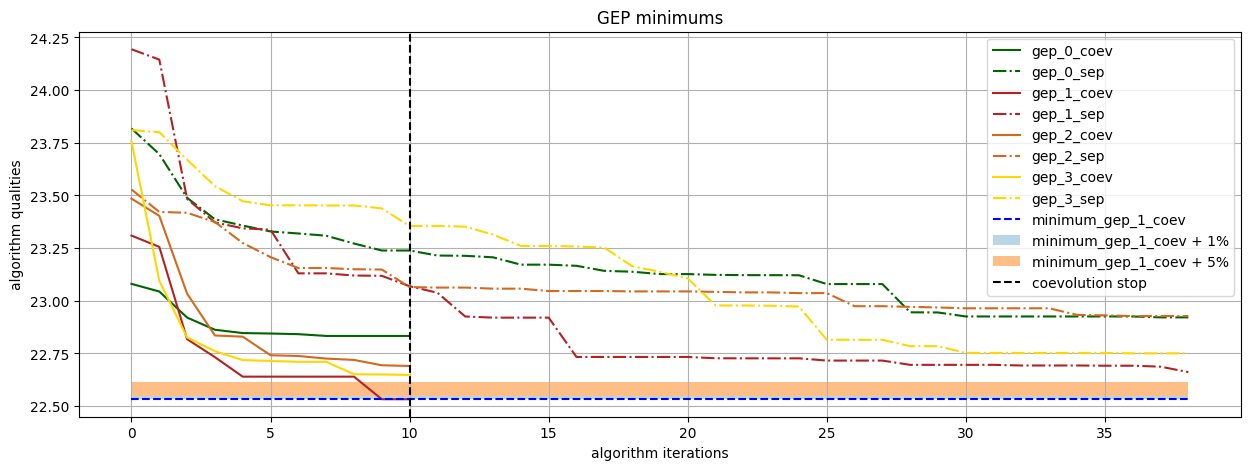

In [9]:
minimum_metrics, qualities_metrics = get_data_from_db('1')
get_qualities(qualities_metrics)
get_minimums(minimum_metrics)

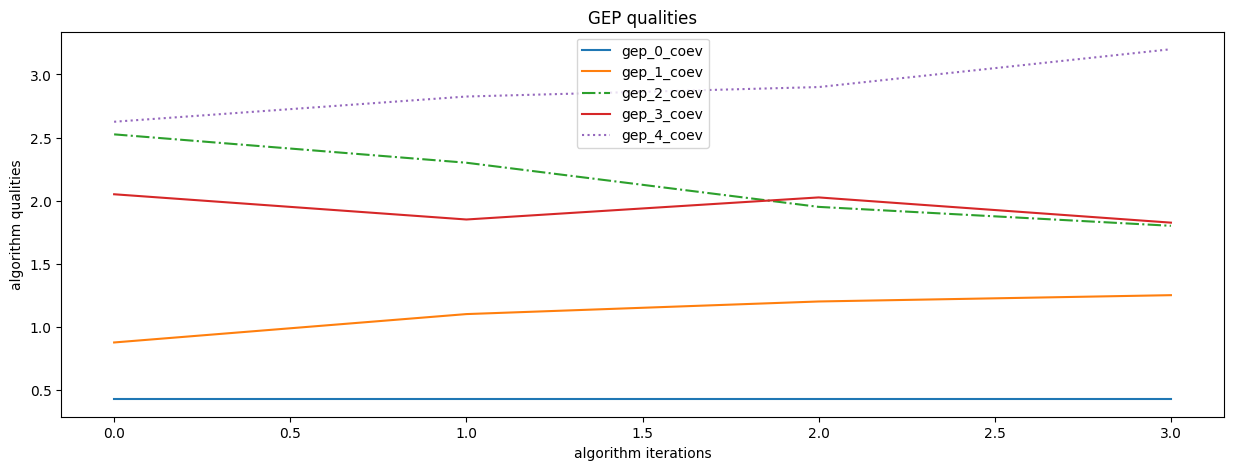


The global minimum is: 24.938862260094357
The global maximum is: 27.08577601489146

Algorithm gep_0_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_0_sep
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 39; 100% of population
Algorithm gep_1_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_1_sep
	Values best+1%: 8; 21% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 31; 79% of population
Algorithm gep_2_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_2_sep
	Values best+1%: 0; 0% of population
	Values between best+1%

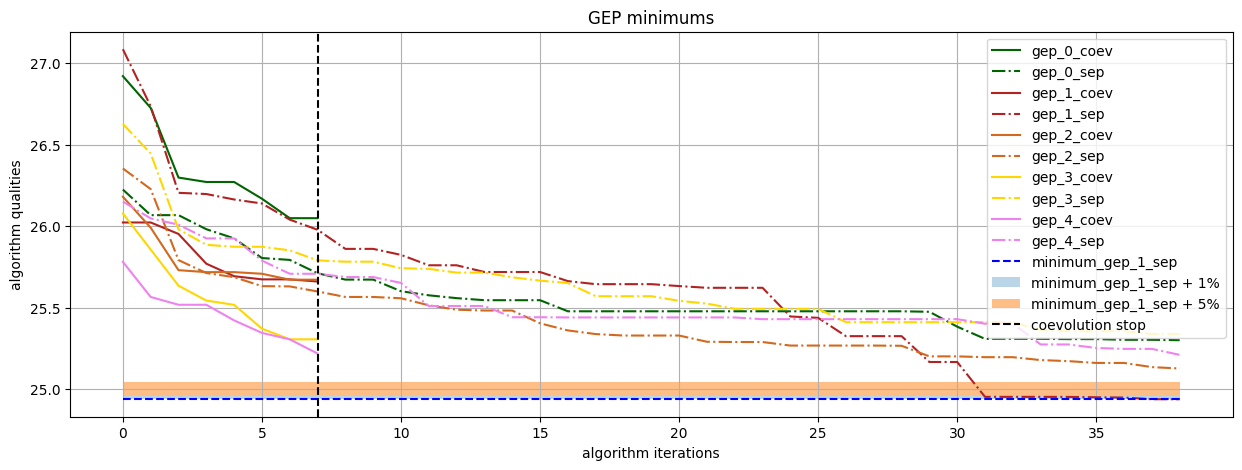

In [10]:
minimum_metrics, qualities_metrics = get_data_from_db('2')
get_qualities(qualities_metrics)
get_minimums(minimum_metrics)

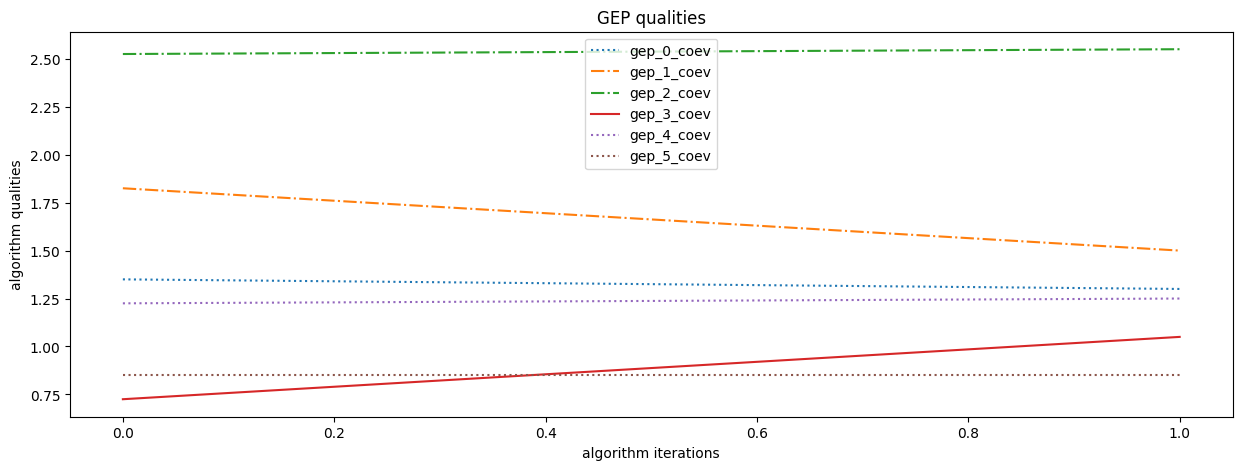


The global minimum is: 20.081534604916065
The global maximum is: 20.407005091371058

Algorithm gep_0_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 6; 100% of population
Algorithm gep_0_sep
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 39; 100% of population
Algorithm gep_1_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 6; 100% of population
Algorithm gep_1_sep
	Values best+1%: 18; 46% of population
	Values between best+1% and best+5%: 9; 23% of population
	Values greater than best+5%: 12; 31% of population
Algorithm gep_2_coev
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 6; 100% of population
Algorithm gep_2_sep
	Values best+1%: 0; 0% of population
	Values between best

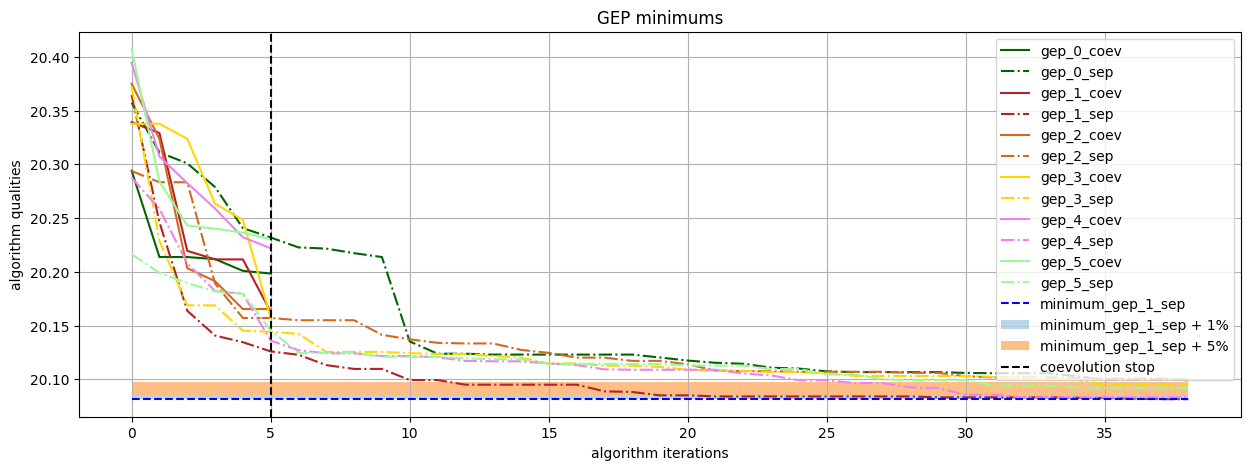

In [11]:
minimum_metrics, qualities_metrics = get_data_from_db('3')
get_qualities(qualities_metrics)
get_minimums(minimum_metrics)